Do not delete this cell. It defines custom LaTeX commands.
$$
\newcommand{\xb}{\boldsymbol{x}}
\newcommand{\wb}{\boldsymbol{w}}
\newcommand{\pb}{\boldsymbol{p}}
\newcommand{\1}{\mathbb{1}}
$$

# Transfer features of image into unseen image with GAN

Authour: Fei Sun, Wei Yan  

This is a first draft of out final project. **(here for project proposal)**

In [1]:
# !pip3 install http://download.pytorch.org/whl/cu80/torch-0.3.1-cp36-cp36m-linux_x86_64.whl
# !pip3 install torchvision

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['axes.grid'] = False

# import math
import numpy as np
# import skimage.data
# import scipy.misc
# import scipy.signal
from scipy import stats
import time
import itertools

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim

from PIL import Image
import glob

In [3]:
from pathlib import Path
HOME = Path.home()
DATA_PATH = HOME / 'datasets' / 'celebA'

# official_mnist_train = torchvision.datasets.MNIST(str(MNIST_PATH), train=True, download=True)
# train_images = official_mnist_train.train_data.numpy().astype(np.float32)

# Part 1: Explore the data

Let's start by loading CelebA database from http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html. CelebFaces Attributes Dataset (CelebA) is a large-scale face attributes dataset with more than 200K celebrity images, each with 40 attribute annotations. For out task, we only neet a small partial of the data (so as to run on laptop cpu). More specifically we pick two or three annotations over 40 attribute annotations. This part is mainly for downloading data and discovering the whole dataset, then select those what we are interested.

CelebA datasets contain various annotated information as below: 

- In-The-Wild Images (Img/img_celeba.7z)
    202,599 original web face images. With size 409 x 687

- Align&Cropped Images (Img/img_align_celeba.zip & Img/img_align_celeba_png.7z)
    202,599 align&cropped face images.

- Bounding Box Annotations (Anno/list_bbox_celeba.txt)
    bounding box labels. See BBOX LABELS h belw for more info.

- Landmarks Annotations (Anno/list_landmarks_celeba.txt & Anno/list_landmarks_align_celeba.txt)
    5 landmark location labels. See LANDMARK LABELS section below for more info.

- Attributes Annotations (Anno/list_attr_celeba.txt)
	40 binary attribute labels. See ATTRIBUTE LABELS section below for more info.

- Evaluation Partitions (Eval/list_eval_partition.txt)
	image ids for training, validation and testing set respectively. See EVALUATION PARTITIONS section below for more info.

The images in this dataset cover large pose variations and background clutter. CelebA has large diversities, large quantities, and rich annotations, including

    10,177 number of identities,

    202,599 number of face images, and

    5 landmark locations, 40 binary attributes annotations per image.


Here we need In-The-Wild Images, their Landmarks Annotations and Attributes Annotations.

In [3]:
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='0B7EVK8r0v71peklHb0pGdDl6R28',
                                    dest_path=str(DATA_PATH),
                                    unzip=True)
# if this won't work, please download manually and unzip them into data
gdd.download_file_from_google_drive(file_id='0B7EVK8r0v71pTzJIdlJWdHczRlU',
                                    dest_path=str(DATA_PATH) + '/list_landmarks_celeba.txt')
gdd.download_file_from_google_drive(file_id='0B7EVK8r0v71pblRyaVFSWGxPY0U', 
                                    dest_path=str(DATA_PATH) + '/list_attr_celeba.txt')


First let's look at all availble annotation attributes:

In [5]:
with open(str(DATA_PATH) +  '/list_attr_celeba.txt', 'r') as f:
    line0 = f.readline() # size=202,599
    attribute = f.readline().strip().split() # attribute=40
    print (attribute)

['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young']


Which one shall we pick? Lack of training data is what we want to avoid, so let's print the number of image each attribute has:

In [6]:
with open(str(DATA_PATH) +  '/list_attr_celeba.txt', 'r') as f:
    line0 = f.readline() # size=202,599
    attribute = f.readline().strip().split() # attribute=40
    
    number = np.zeros(40)
    for line in f:
        line = line.strip().split()
        for i in range(1, 41):
            if line[i] == str(1):
                number[i-1] += 1

In [7]:
for i in range(40):
    print (attribute[i],":  ", number[i])

5_o_Clock_Shadow :   22516.0
Arched_Eyebrows :   54090.0
Attractive :   103833.0
Bags_Under_Eyes :   41446.0
Bald :   4547.0
Bangs :   30709.0
Big_Lips :   48785.0
Big_Nose :   47516.0
Black_Hair :   48472.0
Blond_Hair :   29983.0
Blurry :   10312.0
Brown_Hair :   41572.0
Bushy_Eyebrows :   28803.0
Chubby :   11663.0
Double_Chin :   9459.0
Eyeglasses :   13193.0
Goatee :   12716.0
Gray_Hair :   8499.0
Heavy_Makeup :   78390.0
High_Cheekbones :   92189.0
Male :   84434.0
Mouth_Slightly_Open :   97942.0
Mustache :   8417.0
Narrow_Eyes :   23329.0
No_Beard :   169158.0
Oval_Face :   57567.0
Pale_Skin :   8701.0
Pointy_Nose :   56210.0
Receding_Hairline :   16163.0
Rosy_Cheeks :   13315.0
Sideburns :   11449.0
Smiling :   97669.0
Straight_Hair :   42222.0
Wavy_Hair :   64744.0
Wearing_Earrings :   38276.0
Wearing_Hat :   9818.0
Wearing_Lipstick :   95715.0
Wearing_Necklace :   24913.0
Wearing_Necktie :   14732.0
Young :   156734.0


All attributes has enough data for out task, so do some manual selection. As we are going to transfer the feature into image, by instinct the more distinct the feature is, the easier for our task. We don't want to challenge ourselves with the hardest problem; be mercy to the GAN learners:)

Therefore, we won't pick feature such as '5_o_Clock_Shadow' (which is hard to evaluate) or 'Attractive' (which is too subjective). Let's sample and show several attribute images.

In [43]:
I = 5110 # start from 1, to I; this is the image we consider by far
IMG_ATTR = np.empty([I, 40])
IMG_NAME = np.empty(I)

with open(str(DATA_PATH) +  '/list_attr_celeba.txt', 'r') as f:
    line0 = f.readline() # size=202,599
    attribute = f.readline().strip().split() # attribute=40

    for i in range(I):
        line = f.readline().strip().split()
        IMG_ATTR[i,:] = list(map(int, line[1:]))
#         IMG_NAME[i] = int(line[0][:6])
        # In this case, IMG_ATTR is in order and we don't need IMG_NAME


Note: Since the original data is so large, we now only use part of the data. Assign I(=5110) to be the last image we use, i.e., our current dataset contains I images.

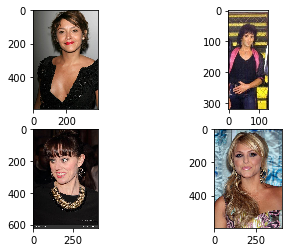

In [60]:
A1 = 'Bangs'
ID1 = attribute.index(A1)

show_no = 4 # total +1 img
rows = 2
columns = 2
fig=plt.figure()
i = 1

for filename in glob.glob(str(DATA_PATH)+'/data/*.jpg'):
    im = Image.open(filename)
#     image_list.append(im)
    img = np.array(im)
    im.close()
    
    if IMG_ATTR[int(filename[-10:-4])-1,ID1] == 1:
        fig.add_subplot(rows, columns, i)
        plt.imshow(img)
        i += 1
    if i > show_no:
        break

## Bangs ↑↑

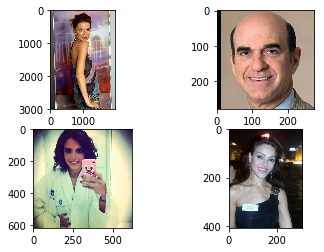

In [61]:
A1 = 'Smiling'
ID1 = attribute.index(A1)

show_no = 4 # total +1 img
rows = 2
columns = 2
fig=plt.figure()
i = 1

for filename in glob.glob(str(DATA_PATH)+'/data/*.jpg'):
    im = Image.open(filename)
#     image_list.append(im)
    img = np.array(im)
    im.close()
    
    if IMG_ATTR[int(filename[-10:-4])-1,ID1] == 1:
        fig.add_subplot(rows, columns, i)
        plt.imshow(img)
        i += 1
    if i > show_no:
        break

## Smiling ↑↑

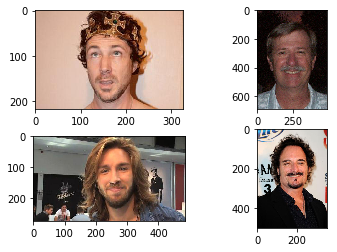

In [62]:
A1 = 'Mustache'
ID1 = attribute.index(A1)

show_no = 4 # total +1 img
rows = 2
columns = 2
fig=plt.figure()
i = 1

for filename in glob.glob(str(DATA_PATH)+'/data/*.jpg'):
    im = Image.open(filename)
#     image_list.append(im)
    img = np.array(im)
    im.close()
    
    if IMG_ATTR[int(filename[-10:-4])-1,ID1] == 1:
        fig.add_subplot(rows, columns, i)
        plt.imshow(img)
        i += 1
    if i > show_no:
        break

## Mustache ↑↑

**maybe some preprocessing alogirthms...? Such as resize?**

In [ ]:
# # Currenly this snippet is unused, but I'm sure we need them in the final project :)
# A1 = 'Bangs'
# A2 = 'Smiling'
# A3 = 'Mustache'
# I = 5110 # start from 1, to I

# img_attribute = np.empty(I, 40)
# with open(str(DATA_PATH) +  '/list_attr_celeba.txt', 'r') as f:
#     line0 = f.readline() # size=202,599
#     attribute = f.readline().strip().split() # attribute=40
#     ID1 = attribute.index(A1)
#     ID2 = attribute.index(A2)
#     IM1 = []
#     IM2 = []
#     for line in f:
#         line = line.strip().split()
#         if line[ID1+1] == str(1):
#             IM1.append(line[0])
#         if line[ID2+1] == str(1):
#             IM2.append(line[0])


# Part 2: some attempts

The very fist idea is to explore GAN. We havn't implemented this before; thus let's build a simple GAN. We basically follow from https://github.com/devnag/pytorch-generative-adversarial-networks, and try with randomly generated data.

Build sampler to obtain Target data and generator input data:

In [1]:
# Data params
data_mean = 4
data_stddev = 1.25

In [65]:
def get_distribution_sampler(mu, sigma):
    return lambda n: torch.Tensor(np.random.normal(mu, sigma, (1, n)))  # Gaussian

def get_generator_input_sampler():
    return lambda m, n: torch.rand(m, n)  # Uniform-dist data into generator, _NOT_ Gaussian

d_sampler = get_distribution_sampler(data_mean, data_stddev)
gi_sampler = get_generator_input_sampler()

In [ ]:
def decorate_with_diffs(data, exponent):
    mean = torch.mean(data.data, 1, keepdim=True)
    mean_broadcast = torch.mul(torch.ones(data.size()), mean.tolist()[0][0])
    diffs = torch.pow(data - Variable(mean_broadcast), exponent)
    return torch.cat([data, diffs], 1)

# ### Uncomment only one of these
#(name, preprocess, d_input_func) = ("Raw data", lambda data: data, lambda x: x)
(name, preprocess, d_input_func) = ("Data and variances", lambda data: decorate_with_diffs(data, 2.0), lambda x: x * 2)


Build Generator model and discriminator model. In this simple GAN they are three fully connected layer plus elu and sigmoid.

In [67]:
# Model params
g_input_size = 1     # Random noise dimension coming into generator, per output vector
g_hidden_size = 50   # Generator complexity
g_output_size = 1    # size of generated output vector
d_input_size = 100   # Minibatch size - cardinality of distributions
d_hidden_size = 50   # Discriminator complexity
d_output_size = 1    # Single dimension for 'real' vs. 'fake'

class Generator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Generator, self).__init__()
        self.map1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.Linear(hidden_size, hidden_size)
        self.map3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.elu(self.map1(x))
        x = F.sigmoid(self.map2(x))
        return self.map3(x)

class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Discriminator, self).__init__()
        self.map1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.Linear(hidden_size, hidden_size)
        self.map3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.elu(self.map1(x))
        x = F.elu(self.map2(x))
        return F.sigmoid(self.map3(x))


G = Generator(input_size=g_input_size, hidden_size=g_hidden_size, output_size=g_output_size)
D = Discriminator(input_size=d_input_func(d_input_size), hidden_size=d_hidden_size, output_size=d_output_size)

Set up optimizer parameters

In [ ]:
d_learning_rate = 2e-4  # 2e-4
g_learning_rate = 2e-4
optim_betas = (0.9, 0.999)

Loss = nn.BCELoss()

d_optimizer = optim.Adam(D.parameters(), lr=d_learning_rate, betas=optim_betas)
g_optimizer = optim.Adam(G.parameters(), lr=g_learning_rate, betas=optim_betas)


Finally, let's trainn

In [ ]:
# costomize training output format
def extract(v):
    return v.data.storage().tolist()

def stats(d):
    return [np.mean(d), np.std(d)]

In [69]:
# Set training parameters
num_epochs = 30000
print_interval = 200
d_steps = 1  # 'k' steps in the original GAN paper. Can put the discriminator on higher training freq than generator
g_steps = 1

minibatch_size = d_input_size

for epoch in range(num_epochs):
    for d_index in range(d_steps):
        # 1. Train D on real+fake
        D.zero_grad()

        #  1A: Train D on real
        d_real_data = Variable(d_sampler(d_input_size))
        d_real_decision = D(preprocess(d_real_data)
        d_real_loss = Loss(d_real_decision), Variable(torch.ones(1)))  # ones = true
        d_real_loss.backward() # compute/store gradients, but don't change params

        #  1B: Train D on fake
        d_gen_data = Variable(gi_sampler(minibatch_size, g_input_size))
        d_fake_data = G(d_gen_data).detach()  # detach to avoid training G on these labels
        d_fake_decision = D(preprocess(d_fake_data.t()))
        d_fake_loss = Loss(d_fake_decision, Variable(torch.zeros(1)))  # zeros = fake
        d_fake_loss.backward()
        d_optimizer.step()     # Only optimizes D's parameters; changes based on stored gradients from backward()

    for g_index in range(g_steps):
        # 2. Train G on D's response (but DO NOT train D on these labels)
        G.zero_grad()

        gen_input = Variable(gi_sampler(minibatch_size, g_input_size))
        g_fake_data = G(gen_input)
        g_fake_decision = D(preprocess(g_fake_data.t()))
        g_error = Loss(g_fake_decision, Variable(torch.ones(1)))  # we want to fool, so pretend it's all genuine

        g_error.backward()
        g_optimizer.step()  # Only optimizes G's parameters

    if epoch % print_interval == 0:
        print("%s: D: %s/%s G: %s (Real: %s, Fake: %s) " % (epoch,
                                                            extract(d_real_loss)[0],
                                                            extract(d_fake_loss)[0],
                                                            extract(g_error)[0],
                                                            stats(extract(d_real_data)),
                                                            stats(extract(d_fake_data))))


/home/phoe/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1189: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


0: D: 0.7933277487754822/0.6921440958976746 G: 0.6853028535842896 (Real: [3.7751464247703552, 1.3560437764989413], Fake: [0.4976778316497803, 0.0066962771215313688]) 
200: D: 3.457074399193516e-06/0.2820057272911072 G: 1.4327582120895386 (Real: [4.0105755805969237, 1.2325895507245663], Fake: [-0.58374737858772274, 0.0051096632526325117]) 
400: D: 4.053123120684177e-06/0.34041640162467957 G: 1.2934019565582275 (Real: [3.8695732560753822, 1.2915848617459991], Fake: [-0.47305960893630983, 0.021386007438621298]) 
600: D: 3.2186549105972517e-06/0.2852596342563629 G: 1.442275881767273 (Real: [3.7689694336056707, 1.3196215235484809], Fake: [-0.44161332935094832, 0.094855046862181325]) 
800: D: -1.000088900582341e-12/0.13917987048625946 G: 2.2721354961395264 (Real: [3.9136502525210379, 1.3985334568741137], Fake: [-0.35452244013547896, 0.34124467332865743]) 
1000: D: 0.0002233635459560901/0.13875898718833923 G: 2.044560194015503 (Real: [3.8743761098384857, 1.3082372026953399], Fake: [1.53704189

10000: D: 0.6970138549804688/0.3361213505268097 G: 0.8176236152648926 (Real: [3.8517949312925337, 1.3608431681116275], Fake: [4.1779513907432557, 1.3058710780129685]) 
10200: D: 0.39928722381591797/0.8378832936286926 G: 0.6995381712913513 (Real: [4.0578697061538698, 1.2818328837969175], Fake: [3.913445147871971, 1.1790821605508004]) 
10400: D: 0.3222470283508301/0.5913227200508118 G: 0.8634912967681885 (Real: [3.9266552853584291, 1.1311080547295476], Fake: [4.173452671766281, 1.1746044280126748]) 
10600: D: 0.3705187439918518/0.6392979621887207 G: 0.5213786363601685 (Real: [4.1659783822298051, 1.1020003086434387], Fake: [4.0270943075418471, 1.2420589678193521]) 
10800: D: 0.8727520704269409/0.648369312286377 G: 1.1485669612884521 (Real: [4.0931844103336337, 1.048055107393536], Fake: [3.9506233745813368, 1.2280367834945405]) 
11000: D: 1.086097240447998/0.432830274105072 G: 0.750878632068634 (Real: [3.8636259621381761, 1.2614852119991813], Fake: [3.731033914089203, 1.250867129473348]) 


19800: D: 0.026547739282250404/0.17649999260902405 G: 1.6138554811477661 (Real: [4.0259113967418667, 1.2363250382307025], Fake: [4.2352248358726499, 1.1556039277425034]) 
20000: D: 0.0193636491894722/0.1155666783452034 G: 3.088520050048828 (Real: [3.9670378708839418, 1.3229820950440043], Fake: [4.0785745704174046, 1.1436769830965712]) 
20200: D: 0.048461392521858215/0.400838702917099 G: 1.1024020910263062 (Real: [3.9201320195198059, 1.3921438565211339], Fake: [3.9885354697704316, 1.3224403921723431]) 
20400: D: 0.16280925273895264/0.15572422742843628 G: 0.6200342178344727 (Real: [4.236157935857773, 1.2504637174289204], Fake: [4.0897349214553831, 1.1605796320037289]) 
20600: D: 0.017785117030143738/0.39267587661743164 G: 0.451802134513855 (Real: [3.7439872598648072, 1.3517620294259458], Fake: [4.142899931669235, 1.2047714048901639]) 
20800: D: 0.11467602849006653/1.111748456954956 G: 0.6688401103019714 (Real: [4.0561986398696899, 1.0879130424379118], Fake: [4.1178161466121672, 1.2937040

29600: D: 0.7307555079460144/0.4395754039287567 G: 0.8708201050758362 (Real: [4.0541710618883373, 1.2205885036966522], Fake: [5.0602218365669254, 1.6122774260814097]) 
29800: D: 1.1546496152877808/0.8079051375389099 G: 1.1025233268737793 (Real: [3.8208727741241457, 1.2716248818141751], Fake: [3.4331919550895691, 1.0360990265570329]) 
